In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

from imblearn.over_sampling import SMOTE

In [2]:
# loading datasets
actives = pd.read_csv('../../mold2_descriptors/2100_actives.csv')
inactives = pd.read_csv('../../mold2_descriptors/2100_inactives.csv')

In [3]:
print('actives:', len(actives))
print('inactives:', len(inactives))

actives: 1165
inactives: 291883


In [4]:
# spliting datasets into test - train & validation
actives_test = actives.sample(n=400, random_state=42)
actives_train = actives.drop(actives_test.index)
inactives_test = inactives.sample(n=400, random_state=42)
inactives_train = inactives.drop(inactives_test.index)

# random undersampling of inactives to prevent memory error
inactives_train = inactives_train.sample(n=100000, random_state=42)

In [5]:
df = pd.concat([actives_train, inactives_train], ignore_index=True)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.12928,-0.671500,0.193548,1.453470,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,4.58496,0.384075,0.000000,0.748000,0
2,2,0,0,1,3,0,0,0,0,0,...,0,0,0,0,0,5.20945,-0.760422,0.413793,2.903180,0
3,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,4.70044,-0.797341,0.272727,2.069140,0
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,4.39232,-0.100701,0.000000,-0.523076,0


In [7]:
X = df.drop(['activity'], axis=1)
y = df['activity']

In [8]:
y.value_counts()

0    100000
1       765
Name: activity, dtype: int64

In [9]:
import matplotlib.pyplot as plt

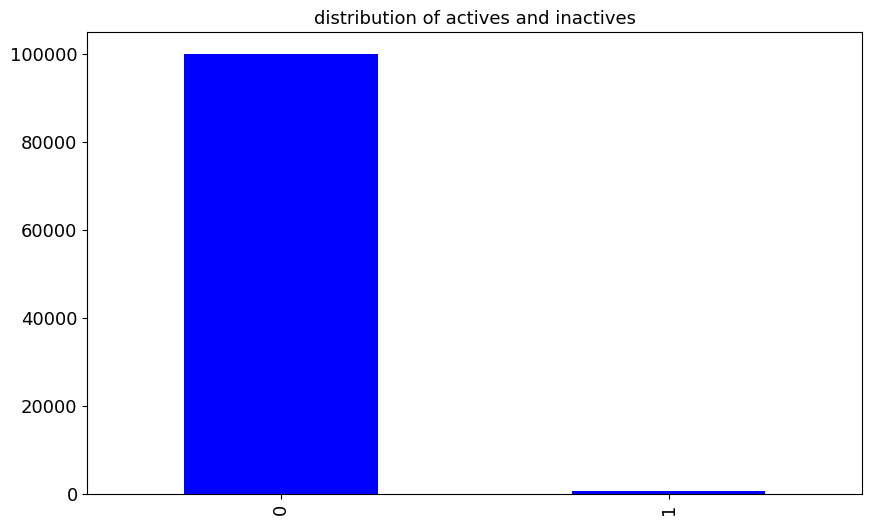

In [10]:
ax = y.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution of actives and inactives', fontsize=13)
ax.set_alpha(0.5)

In [11]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# normalizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)

In [13]:
over = SMOTE()
X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

In [14]:
y_train_resampled.value_counts()

0    69992
1    69992
Name: activity, dtype: int64

Text(0.5, 1.0, 'distribution in sampled dataset')

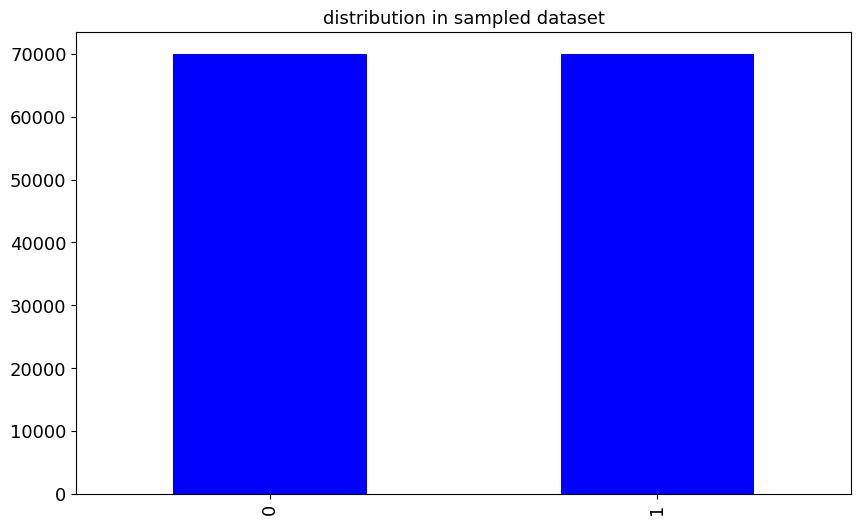

In [15]:
ax = y_train_resampled.value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='blue')
ax.set_title('distribution in sampled dataset', fontsize=13)

## training model with oversampled data

In [16]:
import tensorflow as tf

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_validate, y_validate), epochs=10, batch_size=32)

Epoch 1/10
4375/4375 [==============================] - 24s 5ms/step - loss: 0.1033 - accuracy: 0.9626 - val_loss: 0.1274 - val_accuracy: 0.9816
Epoch 2/10
4375/4375 [==============================] - 25s 6ms/step - loss: 0.0366 - accuracy: 0.9889 - val_loss: 0.2259 - val_accuracy: 0.9728
Epoch 3/10
4375/4375 [==============================] - 24s 5ms/step - loss: 0.0243 - accuracy: 0.9929 - val_loss: 0.1837 - val_accuracy: 0.9872
Epoch 4/10
4375/4375 [==============================] - 22s 5ms/step - loss: 0.0193 - accuracy: 0.9945 - val_loss: 0.1528 - val_accuracy: 0.9892
Epoch 5/10
4375/4375 [==============================] - 20s 5ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.2504 - val_accuracy: 0.9889
Epoch 6/10
4375/4375 [==============================] - 20s 5ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.1332 - val_accuracy: 0.9871
Epoch 7/10
4375/4375 [==============================] - 20s 5ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.2383 - val_ac

### evaluating the model using the test data

In [18]:
# getting the test dataset
testing_data = pd.concat([actives_test, inactives_test], ignore_index=True)

In [19]:
len(testing_data)

800

In [20]:
testing_data['activity'].value_counts()

1    400
0    400
Name: activity, dtype: int64

In [21]:
testing_data.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D769,D770,D771,D772,D773,D774,D775,D776,D777,activity
0,1,0,0,0,2,0,0,0,0,0,...,0,1,0,0,0,5.087,0.343,0.240,0.314,1
1,0,0,0,0,3,0,0,0,0,0,...,0,1,0,0,0,5.087,-0.684,0.000,1.682,1
2,2,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,5.129,0.301,0.462,2.812,1
3,1,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,5.129,-0.323,0.231,1.792,1
4,2,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,5.000,-0.323,0.480,2.594,1


In [22]:
testing_data_x = testing_data.drop(['activity'], axis=1)
print(len(testing_data_x))
testing_data_x = scaler.transform(testing_data_x)
testing_data_y = testing_data['activity']

800


In [23]:
model.evaluate(testing_data_x, testing_data_y, verbose=2)

25/25 - 0s - loss: 6.0506 - accuracy: 0.6450 - 107ms/epoch - 4ms/step


[6.050601959228516, 0.6449999809265137]

### evaluating model's performance with F1 score, precision, recall, etc

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [25]:
inactives_test_x = inactives_test.drop(['activity'], axis=1)
inactives_test_x = scaler.transform(inactives_test_x)
actives_test_x = actives_test.drop(['activity'], axis=1)
actives_test_x = scaler.transform(actives_test_x)

In [26]:
y_true_actives = np.array([1] * len(actives_test_x))
y_true_inactives = np.array([0] * len(inactives_test_x))
y_true = np.concatenate((y_true_actives, y_true_inactives))

There are both y_pred and y_pred_rounded because the model outputs a probability and we need to round it to get the class.


y_pred will be used to calculate the ROC curve and the AUC.


y_pred_rounded will be used to calculate the confusion matrix.

In [27]:
y_pred_actives = model.predict(actives_test_x)
y_pred_actives_rounded = (y_pred_actives > 0.5).astype(int).reshape(len(y_pred_actives, ))
y_pred_inactives = model.predict(inactives_test_x)
y_pred_inactives_rounded = (y_pred_inactives > 0.5).astype(int).reshape(len(y_pred_inactives, ))
y_pred = np.concatenate((y_pred_actives, y_pred_inactives))
y_pred_rounded = np.concatenate((y_pred_actives_rounded, y_pred_inactives_rounded))

13/13 [==============================] - 0s 2ms/step


In [28]:
accuracy = accuracy_score(y_true, y_pred_rounded)
precision = precision_score(y_true, y_pred_rounded)
recall = recall_score(y_true, y_pred_rounded)
f1 = f1_score(y_true, y_pred_rounded)

In [29]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.645
precision is 0.9915254237288136
recall is 0.2925
f1 is 0.4517374517374518


Drawing the ROC curve to enable us to carry out threshold moving,

In [30]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)

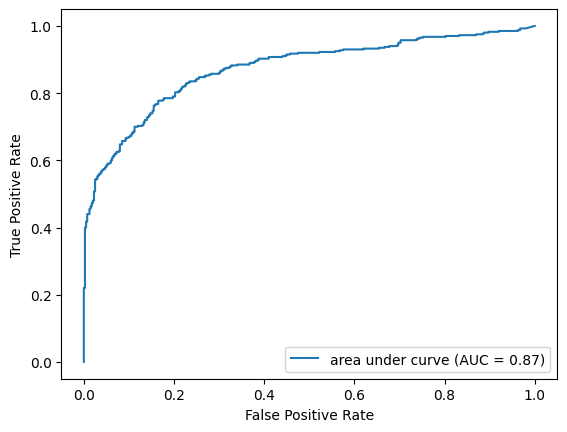

In [31]:
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='area under curve')
display.plot()
plt.show()

In [37]:
fav_thresholds = []
for i in range(len(thresholds)):
    if fpr[i] < 0.25 and tpr[i] > 0.8:
        fav_thresholds.append((i, thresholds[i], fpr[i], tpr[i]))

In [38]:
for i in fav_thresholds:
    print(i)

(113, 1.930765e-09, 0.2025, 0.8025)
(114, 1.8247022e-09, 0.21, 0.8025)
(115, 1.6730872e-09, 0.21, 0.805)
(116, 1.6608146e-09, 0.2125, 0.805)
(117, 1.6376878e-09, 0.2125, 0.8075)
(118, 1.4101013e-09, 0.215, 0.8075)
(119, 1.2146817e-09, 0.215, 0.8125)
(120, 1.1952159e-09, 0.2175, 0.8125)
(121, 1.1548161e-09, 0.2175, 0.8175)
(122, 1.1061786e-09, 0.22, 0.8175)
(123, 1.096616e-09, 0.22, 0.82)
(124, 1.0434944e-09, 0.225, 0.82)
(125, 7.880586e-10, 0.225, 0.825)
(126, 7.194898e-10, 0.2275, 0.825)
(127, 6.1231653e-10, 0.2275, 0.83)
(128, 5.1288856e-10, 0.2325, 0.83)
(129, 5.1076526e-10, 0.2325, 0.8325)
(130, 4.71547e-10, 0.235, 0.8325)
(131, 3.8145692e-10, 0.235, 0.835)
(132, 3.0369274e-10, 0.2475, 0.835)
(133, 2.7821676e-10, 0.2475, 0.8375)


In [39]:
selected_threshold = fav_thresholds[-1][1]
selected_threshold

2.7821676e-10

In [40]:
y_pred_actives_rounded2 = (y_pred_actives > selected_threshold).astype(int).reshape(len(y_pred_actives, ))
y_pred_inactives_rounded2 = (y_pred_inactives > selected_threshold).astype(int).reshape(len(y_pred_inactives, ))
y_pred_rounded2 = np.concatenate((y_pred_actives_rounded2, y_pred_inactives_rounded2))

In [41]:
accuracy = accuracy_score(y_true, y_pred_rounded2)
precision = precision_score(y_true, y_pred_rounded2)
recall = recall_score(y_true, y_pred_rounded2)
f1 = f1_score(y_true, y_pred_rounded2)

In [42]:
print("accuracy is {}".format(accuracy))
print("precision is {}".format(precision))
print("recall is {}".format(recall))
print("f1 is {}".format(f1))

accuracy is 0.79375
precision is 0.7713625866050808
recall is 0.835
f1 is 0.801920768307323
